In [10]:
import pandas as pd

# Direct path to your parquet file
file_path = '-/birth_year_with_political_leaning.parquet'

# Read the parquet file
df = pd.read_parquet(file_path)

# Verify the data was loaded
print(f"DataFrame shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '-/birth_year_with_political_leaning.parquet'

Original class distribution:
predicted_political_leaning
center    24104
left      10152
right      7617
Name: count, dtype: int64

Percentage distribution:
predicted_political_leaning
center    57.56454
left      24.24474
right     18.19072
Name: proportion, dtype: float64

Balanced class distribution:
predicted_political_leaning
center    7617
left      7617
right     7617
Name: count, dtype: int64

Training FastText model...
Creating embeddings...

Performing parameter optimization...

Trying C=1, gamma=scale

Trying C=1, gamma=auto

Trying C=1, gamma=0.1

Trying C=1, gamma=0.01

Trying C=10, gamma=scale

Trying C=10, gamma=auto

Trying C=10, gamma=0.1

Trying C=10, gamma=0.01

Trying C=100, gamma=scale

Trying C=100, gamma=auto

Trying C=100, gamma=0.1

Trying C=100, gamma=0.01

Best parameters found: {'C': 1, 'gamma': 0.1}
Best score: 0.5318311091664844

--- Final Model Performance ---

Classification Report:
              precision    recall  f1-score   support

      center     

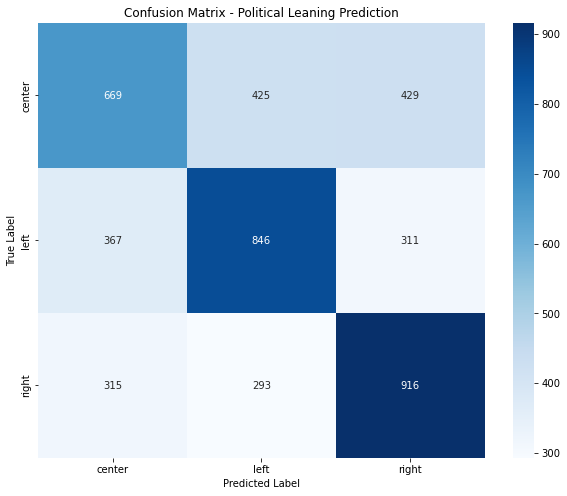


Models saved successfully.


In [9]:
import pandas as pd
import numpy as np
from gensim.models.fasttext import FastText
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load political leaning dataset
file_path = '-/birth_year_with_political_leaning.parquet'
df_political = pd.read_parquet(file_path)

# Perform random sampling for class balancing
def balance_classes(df, target_column):
    # Get the size of the smallest class
    min_class_size = df[target_column].value_counts().min()
    
    # Sample equal number of instances from each class
    balanced_dfs = []
    for class_label in df[target_column].unique():
        class_df = df[df[target_column] == class_label]
        sampled_df = class_df.sample(n=min_class_size, random_state=42)
        balanced_dfs.append(sampled_df)
    
    # Concatenate all balanced classes
    balanced_df = pd.concat(balanced_dfs, axis=0).reset_index(drop=True)
    return balanced_df

# Print original distribution
print("Original class distribution:")
print(df_political['predicted_political_leaning'].value_counts())
print("\nPercentage distribution:")
print(df_political['predicted_political_leaning'].value_counts(normalize=True) * 100)

# Balance the dataset
df_balanced = balance_classes(df_political, 'predicted_political_leaning')
print("\nBalanced class distribution:")
print(df_balanced['predicted_political_leaning'].value_counts())

# Create FastText embeddings
def create_fasttext_embeddings(texts, vector_size=100, window=5, min_count=1):
    processed_texts = [text.split() for text in texts]
    model = FastText(sentences=processed_texts, 
                    vector_size=vector_size,
                    window=window,
                    min_count=min_count,
                    workers=4)
    return model

# Convert text to embeddings
def get_text_embedding(text, fasttext_model):
    words = text.split()
    vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    if not vectors:
        return np.zeros(fasttext_model.vector_size)
    return np.mean(vectors, axis=0)

# Create FastText embeddings using balanced dataset
print("\nTraining FastText model...")
fasttext_model = create_fasttext_embeddings(df_balanced['post'].values)

# Convert texts to embeddings
print("Creating embeddings...")
X = np.array([get_text_embedding(text, fasttext_model) for text in df_balanced['post'].values])
y = df_balanced['predicted_political_leaning']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Manual parameter optimization
print("\nPerforming parameter optimization...")
C_values = [1, 10, 100]
gamma_values = ['scale', 'auto', 0.1, 0.01]
best_score = 0
best_model = None
best_params = {}

results = []
for C in C_values:
    for gamma in gamma_values:
        print(f"\nTrying C={C}, gamma={gamma}")
        svm = SVC(kernel='rbf', 
                  C=C, 
                  gamma=gamma,
                  probability=True,
                  random_state=42)
        
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        score = svm.score(X_test, y_test)
        
        results.append({
            'C': C,
            'gamma': gamma,
            'score': score,
            'report': classification_report(y_test, y_pred, output_dict=True)
        })
        
        if score > best_score:
            best_score = score
            best_model = svm
            best_params = {'C': C, 'gamma': gamma}

print("\nBest parameters found:", best_params)
print("Best score:", best_score)

# Final evaluation with best model
print("\n--- Final Model Performance ---")
y_pred_final = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Plot confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['center', 'left', 'right'],
            yticklabels=['center', 'left', 'right'])
plt.title('Confusion Matrix - Political Leaning Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save models
import joblib
joblib.dump(best_model, 'political_leaning_svm.joblib')
joblib.dump(fasttext_model, 'fasttext_model.joblib')

print("\nModels saved successfully.")